In [0]:
# Let's install tensorflow 2.x first :)
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [0]:
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import tensorflow as tf
import numpy as np 
import os
import matplotlib.pyplot as plt

In [0]:
BASE_URL = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com"
DATASET_NAME = "sonnets.txt"
DATASET_FOLDER = "./datasets"

In [7]:
!mkdir $DATASET_FOLDER

mkdir: cannot create directory ‘./datasets’: File exists


In [0]:
dataset_url = os.path.join(BASE_URL,DATASET_NAME)
dataset_path = os.path.join(DATASET_FOLDER, DATASET_NAME)

In [9]:
!wget $dataset_url -O $dataset_path

--2019-12-08 21:01:26--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 2a00:1450:400c:c0c::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘./datasets/sonnets.txt’

./datasets/sonnets. 100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2019-12-08 21:01:26 (131 MB/s) - ‘./datasets/sonnets.txt’ saved [93578/93578]



In [0]:
# Open the file 
data = open(dataset_path).read()
# Take the data and lower case it and split it between lines
corpus = data.lower().split("\n")

In [11]:
corpus[:4]

['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:']

In [0]:
# Create the tokenizer 
tokenizer = Tokenizer()

# Create the tokens for each word  in the corpus 
tokenizer.fit_on_texts(corpus)

# get the total number of words + 1 ( out of vocab word )
total_words = len(tokenizer.word_index) + 1

In [0]:
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
  # generate the sequences
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    # generate the ngram
    n_gram_sequence = token_list[:i+1]
    input_sequences.append(n_gram_sequence)

In [14]:
input_sequences[:5]

[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [0]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [16]:
# Let's show the first 4 generated and padded sequences
input_sequences[:4]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,  34, 417],
       [  0,   0,   0,   0,   0,   0,   0,   0,  34, 417, 877],
       [  0,   0,   0,   0,   0,   0,   0,  34, 417, 877, 166],
       [  0,   0,   0,   0,   0,   0,  34, 417, 877, 166, 213]],
      dtype=int32)

In [17]:
# create predictors and label
# predictors: let's take all but the last
# labels: let's take only the last to be the label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
print(label[0:4])

[417 877 166 213]


In [0]:
# Change the labels to be categorical ( one hot encoding )
label = ku.to_categorical(label, num_classes=total_words)


In [19]:
# From the label above the first value is 417, so this value on the vector is one
print(label[0][417])

1.0


In [0]:
VOCAB_SIZE = total_words
EMBEDDING_DIM = 32
BATCH_SIZE = 64

In [0]:
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(l=0.001)))
model.add(Dense(total_words, activation='softmax'))

In [22]:
# Pick an optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 32)            102752    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           219600    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 5,801,723
Trainable params: 5,801,723
Non-trainable params: 0
______________________________________________

In [23]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Train on 15462 samples
Epoch 1/100
15462/15462 [==============================] - 20s 1ms/sample - loss: 6.8510 - accuracy: 0.0210
Epoch 2/100
15462/15462 [==============================] - 12s 801us/sample - loss: 6.5000 - accuracy: 0.0221
Epoch 3/100
15462/15462 [==============================] - 12s 798us/sample - loss: 6.3736 - accuracy: 0.0274
Epoch 4/100
15462/15462 [==============================] - 12s 803us/sample - loss: 6.2373 - accuracy: 0.0352
Epoch 5/100
15462/15462 [==============================] - 12s 807us/sample - loss: 6.1131 - accuracy: 0.0388
Epoch 6/100
15462/15462 [==============================] - 12s 805us/sample - loss: 5.9711 - accuracy: 0.0426
Epoch 7/100
15462/15462 [==============================] - 12s 804us/sample - loss: 5.8158 - accuracy: 0.0471
Epoch 8/100
15462/15462 [==============================] - 12s 802us/sample - loss: 5.6571 - accuracy: 0.0561
Epoch 9/100
15462/15462 [==============================] - 12s 806us/sample - loss: 5.4846 - accura

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [0]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  #plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

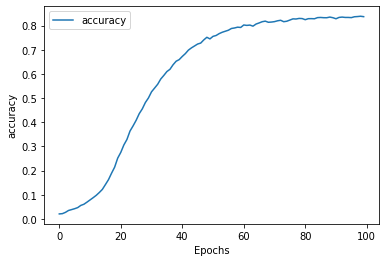

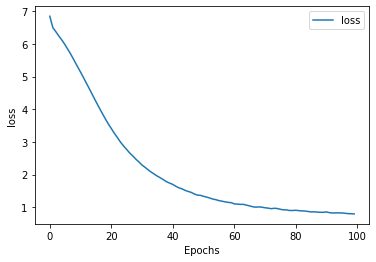

In [35]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [36]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope their treasure knit cross cross seen night arising lie to be near store it sit bristly near near make be ' more ill was more made to wilt mine eyes best none see thee not of it old bold seen green thee told so true ' will know me hate thee so bold not green thee not told not so word me thee in thee not so bold behold thee not not not not so ill so bold not said not praise not not thy praise alone left thy time is true ' are ' had seen heart are bevel
